In [99]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [100]:
#@title Define Hyperparameters

input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 10 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-2 # size of step 

In [101]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [102]:
#@title Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [103]:
from torch.autograd import Function

class PhotonCountingP(nn.Module):
    """ The probability of 1 photon in photon counting 
        (also the expectation value) with mean flux x """
    def __init__(self):
        super(PhotonCountingP, self).__init__()

    def forward(self, x):
        return 1.-torch.exp(torch.abs(x)*-1.)
    
class BernoulliFunctionST(Function):
    """ The 'Straight Through' stochastic Bernoulli activation"""
    @staticmethod
    def forward(ctx, input):

        return torch.bernoulli(input)

    @staticmethod
    def backward(ctx, grad_output):

        return grad_output

class PoissonFunctionST(Function):
    """ The 'Straight Through' stochastic Poisson activation"""
    @staticmethod
    def forward(ctx, input):

        return torch.poisson(input)

    @staticmethod
    def backward(ctx, grad_output):

        return grad_output
    
PoissonST = PoissonFunctionST.apply    
BernoulliST = BernoulliFunctionST.apply 

In [104]:
#@title Define model class

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, scale = 1, slope = 1, repeat = 5):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
    self.act = PhotonCountingP()
    self.sampler = BernoulliST
    self.scale = scale
    self.slope = slope
    self.repeat = repeat
  
  def forward(self,x):
    out = self.fc1(x)
    # out = self.relu(out)
    probs = self.act(self.slope * out)
    out = self.sampler(probs.unsqueeze(0).repeat((self.repeat,)+(1,)*len(probs.shape))).mean(axis=0)*torch.sign(out)
    out = self.fc2(out)
    return out

In [105]:
#@title Build the model

# if torch.cuda.is_available():
#   net.cuda()

In [134]:
#@title Training the model

accuracies = []
photonCounts = []

finalaccuracies = []
finalCounts = []

for j in range(4):
  count = j + 1
  net = Net(input_size, hidden_size, num_classes, repeat= count)
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam( net.parameters(), lr=lr)
  for epoch in range(num_epochs):
    for i ,(images,labels) in enumerate(train_gen):
      images = Variable(images.view(-1,28*28))
      labels = Variable(labels)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      
      if (i+1) % 100 == 0:
        print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Accuracy: %.1f'
                  %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item(), accuracy))
        correct = 0
        total = 0
        for images,labels in test_gen:
          images = Variable(images.view(-1,28*28))
          labels = labels
          
          output = net(images)
          _, predicted = torch.max(output,1)
          correct += (predicted == labels).sum()
          total += labels.size(0)

          accuracy = (100*correct)/(total+1)

          accuracies.append(accuracy)
          photonCounts.append(count)
  finalaccuracies.append(accuracy)
  finalCounts.append(count)
      

Epoch [1/10], Step [100/600], Loss: 0.3892, Accuracy: 95.6
Epoch [1/10], Step [200/600], Loss: 0.2741, Accuracy: 90.9
Epoch [1/10], Step [300/600], Loss: 0.1350, Accuracy: 92.9
Epoch [1/10], Step [400/600], Loss: 0.4040, Accuracy: 92.0
Epoch [1/10], Step [500/600], Loss: 0.1420, Accuracy: 94.4
Epoch [1/10], Step [600/600], Loss: 0.1634, Accuracy: 94.8
Epoch [2/10], Step [100/600], Loss: 0.2176, Accuracy: 94.9
Epoch [2/10], Step [200/600], Loss: 0.1461, Accuracy: 94.5
Epoch [2/10], Step [300/600], Loss: 0.1420, Accuracy: 95.8
Epoch [2/10], Step [400/600], Loss: 0.2905, Accuracy: 95.0
Epoch [2/10], Step [500/600], Loss: 0.0724, Accuracy: 94.5
Epoch [2/10], Step [600/600], Loss: 0.0662, Accuracy: 95.0
Epoch [3/10], Step [100/600], Loss: 0.0598, Accuracy: 96.0
Epoch [3/10], Step [200/600], Loss: 0.1023, Accuracy: 94.6
Epoch [3/10], Step [300/600], Loss: 0.2005, Accuracy: 95.3
Epoch [3/10], Step [400/600], Loss: 0.3063, Accuracy: 95.1
Epoch [3/10], Step [500/600], Loss: 0.0519, Accuracy: 94

In [135]:

for i in range(len(accuracies)):
    accuracies[i] = accuracies[i].item()

for i in range(len(finalaccuracies)):
    finalaccuracies[i] = finalaccuracies[i].item()

In [136]:
#@title Evaluating the accuracy of the model

correct = 0
total = 0
for images,labels in test_gen:
  images = Variable(images.view(-1,28*28))
  labels = labels
  
  output = net(images)
  _, predicted = torch.max(output,1)
  correct += (predicted == labels).sum()
  total += labels.size(0)

print('Accuracy of the model: %.3f %%' %((100*correct)/(total+1)))

Accuracy of the model: 96.300 %


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

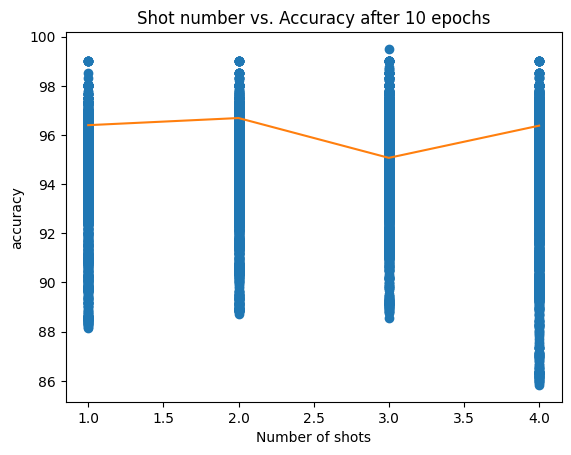

In [139]:
import matplotlib.pyplot as plt
print(photonCounts)
print(accuracies)
plt.plot(photonCounts, accuracies, 'o')
plt.plot(finalCounts, finalaccuracies)
plt.xlabel('Number of shots')
plt.ylabel('accuracy')
plt.title('Shot number vs. Accuracy after 10 epochs')
plt.show()